In [38]:
import torch
import torch.nn as nn
import torchsummary
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import models

In [5]:
letter_model = models.letter_model('resnext50_32x4d')

In [3]:
with open('ckpt-epoch038-val_loss0.5396-val_acc0.8537.pth', 'rb') as f:
    data = torch.load(f)

In [6]:
letter_model.load_state_dict(data['model_state_dict'])

<All keys matched successfully>

In [10]:
children = list(letter_model.children())

In [113]:
children[4]

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

In [109]:
children

[Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 LeakyReLU(negative_slope=0.01, inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
     (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): LeakyReLU(negative_slope=0.01, inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride

In [23]:
train = pd.read_csv('data/train.csv')

In [25]:
def parse_csv(csv: pd.DataFrame):
    X = (csv[[str(i) for i in range(784)]]).values.reshape(-1, 28, 28, 1).astype(np.uint8)
    X = np.stack(X)

    char2num = {chr(i): i - 65 for i in range(65, 91)}
    # num2char = {i - 65: chr(i) for i in range(65, 91)}

    if 'digit' in csv.columns:
        Y = np.array([v for v in csv['digit'].values], dtype=np.int64)
    else:
        Y = None

    Z = np.array([char2num[v] for v in csv['letter'].values], dtype=np.int64)

    return X, Y, Z

In [28]:
X, Y, Z = parse_csv(train)

In [73]:
def _preprocess(img: np.ndarray) -> torch.Tensor:
    # LANCZOS 등은 blur 효과가 강해서, 여기에서는 별로인듯. qubic이 좋겠음.
    img = cv2.resize(img, (280, 280))
    img = np.squeeze(img).astype(np.float32) / 255.
    img2 = img * (img >= 0.549)  # 140 / 255

    img_comb = np.stack([img, img2], axis=2)
    img_comb = torch.tensor(img_comb, dtype=torch.float32)
    img_comb = img_comb.permute([2, 0, 1])
    return img_comb

In [74]:
x = _preprocess(X[11])

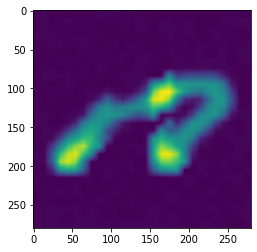

In [75]:
plt.imshow(x[0].numpy())

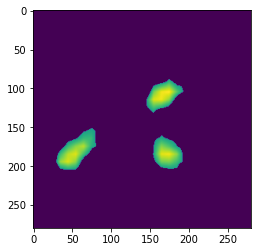

In [76]:
plt.imshow(x[1].numpy())

In [164]:
children[8]

AdaptiveAvgPool2d(output_size=(1, 1))

In [158]:
feat_out = nn.Sequential(*children[:8])

In [160]:
with torch.no_grad():
    feat_out.eval()
    feat = feat_out(torch.unsqueeze(x, dim=0))

In [161]:
feat.shape

torch.Size([1, 2048, 9, 9])

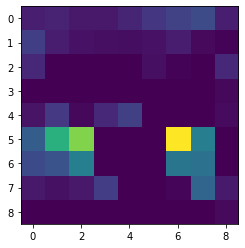

In [162]:
plt.imshow(feat[0, 2000])